<a href="https://colab.research.google.com/github/anushka-code/Code-Smell-Classification/blob/main/Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML Model using Sci-Kit Learn - Random Forest Classifier & TF IDF Vectorizer for Combined Input of Numerical and Textual Features

###Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import imblearn
from imblearn.over_sampling import SMOTE
import nltk 
from nltk.tokenize import RegexpTokenizer
import re

###Mounting Google Drive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

###Dataset Loader

In [4]:
def DataLoader(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  dataframe = pd.read_csv(name_of_file)
  return dataframe


link1 = 'https://drive.google.com/file/d/1EfbAqgr7i9h4yFwEoU3igG34Gt48l6WT/view?usp=sharing'
link2 = 'https://drive.google.com/file/d/1Ya1OMWsz1yyXAaZheIck-roX0M9UWiqg/view?usp=sharing'
link6 = 'https://drive.google.com/file/d/1rLkJAwHkBAAkHMp2L1Y1AzuniIZdyB7x/view?usp=sharing'

name1 = 'long_parameters_list_structural.csv'
name2 = 'switch_statements_structural.csv'
name6 = 'semantic_final.csv'

df_lp = DataLoader(link1, name1)
df_ss = DataLoader(link2, name2)
df_semantic = DataLoader(link6,name6)

###Data Pre-Processing of Structural Dataset

In [5]:
def PrePro(last_column, dataframe):
  dataframe.rename(columns = {last_column :'is_code_smell'}, inplace = True) #rename column
  dataframe['is_code_smell'] = dataframe["is_code_smell"].astype(int) #change boolean labels to int labels
  Y_part = dataframe.iloc[:,-1:]
  X_part = dataframe.iloc[:,:56]
  X_part = X_part.replace(to_replace =["?"], value = np.nan) #replace non existing values with null
  X_part = X_part.astype(float) #change datatype of features of X as float
  return X_part,Y_part

X_lp, Y_lp = PrePro('is_long_parameters_list',df_lp)
X_ss, Y_ss = PrePro('is_switch_statements',df_ss)

In [8]:
def MeanforNaN(dataframe):   #function to fill null spaces with column mean 
  column_means = dataframe.mean()
  dataframe = dataframe.fillna(column_means)
  return dataframe

X_lp = MeanforNaN(X_lp)
X_ss = MeanforNaN(X_ss)

In [9]:
def ConCat(df1,df2): #concatenate code smell datasets
  code_smells = [df1,df2]
  joint = pd.concat(code_smells)
  return joint

X_train = ConCat(X_lp,X_ss)
Y_train = ConCat(Y_lp,Y_ss)

In [14]:
def Normalize(dataframe): #apply MinMax normalisation to fit the values between 0 to 1
  scaler = MinMaxScaler()
  model = scaler.fit(dataframe)
  scaled_data = model.transform(dataframe)
  return scaled_data

X_sample = Normalize(X_train)
Y_sample = Y_train.to_numpy(dtype='int64', copy='True')

In [30]:
len(Y_sample)

840

###Synthetic Minority Oversampling Technique (SMOTE) Algo for Imbalanced Datasets

In [13]:
Y_train.value_counts()  #1/3rd are smelly, 2/3rd are non smelly 

is_code_smell
0                573
1                267
dtype: int64

In [15]:
def Oversample(X_data,Y_data): # Using Smote obtain a 50-50 balanced dataset 

  sm = SMOTE(random_state = 2)
  X_train_res, Y_train_res = sm.fit_resample(X_data, Y_data.ravel())
  return X_train_res, Y_train_res

X_new, Y_new = Oversample(X_sample,Y_sample)

###Text Pre Processing

In [16]:
def PrePro2(dataframe):
  X_part = dataframe.iloc[:,:-1]  
  return X_part

X_sem= PrePro2(df_semantic) #separate as X and Y columns

In [17]:
def ToList(dataframe, string): #converts pandas.core.series.Series to list of lists
  new_column = dataframe[string].tolist()
  return list(map(lambda x:[x], new_column))

class_words = ToList(X_sem, 'class')
method_words = ToList(X_sem, 'method')

### Tokenization

In [18]:
def TokenizeGroups(text): #tokenizes as per CamelCase RegEx and converts to lowercase
  tokenizer = RegexpTokenizer('[a-zA-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))') # RegEx pattern for CamelCase 
  useful_text = tokenizer.tokenize(text) 
  useful_text = [x.lower() for x in useful_text]
  return useful_text

In [19]:
def LoopOver(list): #loops over all the samples to tokenize all the strings in each word group
  for i in range(0,1146):
    list[i] = TokenizeGroups(list[i][0])
    i=i+1
  return list

class_words_sem = LoopOver(class_words)
method_words_sem = LoopOver(method_words)

In [20]:
def WordList(list1,list2): #concatenate the words of each project, package, class and method
  final_list = []
  for i in range(0,1146):
    x = list1[i] + list2[i]
    final_list.append(x)
  res = [' '.join(ele) for ele in final_list]
  return res

word_groups = WordList(class_words_sem, method_words_sem)

###Machine Learning Pipeline of Feature Union - Random Forest Classifier TF-IDF Vectorizer

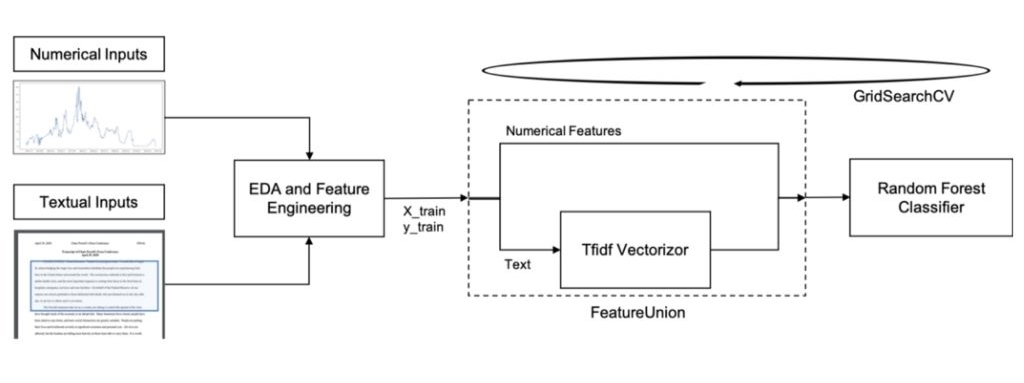

In [23]:
X_struct = pd.DataFrame(X_new)

In [26]:
words = pd.DataFrame(word_groups)

In [29]:
X_final = pd.concat([X_struct, words], axis=1) # combining the structural and semantic data
X_ml_final = X_final.to_numpy() # converting df into numpy array

Stratified K-Fold Cross Validation

In [32]:
def CrossValidation(dataX,dataY): #split the dataset into train and test using k-5 fold cross validation
  skf = StratifiedKFold(n_splits=5, random_state = None, shuffle=True) 

  for train_index, test_index in skf.split(dataX , dataY):
        X_crosstrain, X_crosstest = dataX[train_index], dataX[test_index] 
        Y_crosstrain, Y_crosstest = dataY[train_index], dataY[test_index]
        return X_crosstrain,X_crosstest,Y_crosstrain,Y_crosstest

X_crosstrain,X_crosstest,Y_crosstrain,Y_crosstest = CrossValidation(X_ml_final, Y_new)

Pipeline

In [33]:
def get_numeric_data(x):
    return [record[:-2].astype(float) for record in x] #gets the numeric data which is all the columns except last column

def get_text_data(x):
    return [record[-1] for record in x] # gets the text data which is the last column of the dataset

transformer_numeric = FunctionTransformer(get_numeric_data) #transformer_numeric when transformed on some X will apply get_numeric_data on X
transformer_text = FunctionTransformer(get_text_data)

In [34]:
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transformer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word'))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

param_grid = {'clf__n_estimators': np.linspace(1, 100, 42, dtype=int),
              'clf__min_samples_split': [2],
              'clf__min_samples_leaf': [1],
              'clf__max_features': [8],
              'clf__max_depth': [None],
              'clf__criterion': ['entropy'],
              'clf__bootstrap': [False]}

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

ML Model

In [35]:
def ML_codesmell(X_tr, Y_tr, X_ts, Y_ts):
  rf_model = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring,refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
  rf_model.fit(X_tr, Y_tr)
  model_score = rf_model.score(X_ts, Y_ts)
  y_pred_test = rf_model.predict(X_ts)
  accuracy = accuracy_score(Y_ts, y_pred_test)
  classification = classification_report(Y_ts, y_pred_test)
  return model_score, accuracy, classification

model_score, accuracy_score, classification_report = ML_codesmell(X_crosstrain, Y_crosstrain, X_crosstest, Y_crosstest)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


###Results

In [36]:
print("Model Score : ", model_score)
print("Accuracy Score : ", accuracy_score)
print("Classification Report : ", classification_report)

Model Score :  0.8955257778787191
Accuracy Score :  0.8956521739130435
Classification Report :                precision    recall  f1-score   support

           0       0.93      0.86      0.89       115
           1       0.87      0.93      0.90       115

    accuracy                           0.90       230
   macro avg       0.90      0.90      0.90       230
weighted avg       0.90      0.90      0.90       230

